### Figure S12: Fig 1a with monthly data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import pyproj
from datetime import datetime, timedelta
from xhistogram.xarray import histogram
import matplotlib.ticker as mticker
import intake

In [2]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45941/status,
Dashboard: /proxy/45941/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46819,Workers: 0
Dashboard: /proxy/45941/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33051,Total threads: 1
Dashboard: /proxy/40979/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:33781,


In [3]:
# Load observational data

# Paolo melt rates
# Load melt datasets:
melt_dataset = xr.open_dataset('/g/data/jk72/or6852/ANT_G1920V01_IceShelfMelt.nc',engine='netcdf4')
# calculate lon and lat of the basal melt file \n",
inProj = Proj(init='epsg:3031')
outProj = Proj(init='epsg:4326')
bas_lon,bas_lat = transform(inProj,outProj,melt_dataset.melt_mean.x,melt_dataset.melt_mean.y)
x2d, y2d = np.meshgrid(melt_dataset.melt.x, melt_dataset.melt.y)
bas_lon2d,bas_lat2d = transform(inProj,outProj,x2d, y2d)
melt_dataset.coords['lat'] = (melt_dataset.melt_mean.dims, bas_lat2d)
melt_dataset.coords['lon'] = (melt_dataset.melt_mean.dims, bas_lon2d)
pib_meltid = melt_dataset.melt.where(melt_dataset.ID.isin([54,55, 56,181,182])).where(~np.isnan(melt_dataset.melt[-1,:,:])).mean({'x','y'})# IDs for Crosson, PIG, Cosgrove, Thwaites W, Thwaites E, 

# Davison melt rates
dav_pig = pd.read_csv('/g/data/jk72/or6852/ensoant/Pine_Island-timeseries.csv',parse_dates=[1])
dav_pig_melt = xr.DataArray(dav_pig['bm_monthly'],dims={'time':dav_pig.dates_datetime},coords={'time':dav_pig.dates_datetime,'area':dav_pig.area_km2[0]})
dav_abb = pd.read_csv('/g/data/jk72/or6852/ensoant/Abbot-timeseries.csv',parse_dates=[1])
dav_abb_melt = xr.DataArray(dav_abb['bm_monthly'],dims={'time':dav_abb.dates_datetime},coords={'time':dav_abb.dates_datetime,'area':dav_abb.area_km2[0]})
dav_cos = pd.read_csv('/g/data/jk72/or6852/ensoant/Cosgrove-timeseries.csv',parse_dates=[1])
dav_cos_melt = xr.DataArray(dav_cos['bm_monthly'],dims={'time':dav_cos.dates_datetime},coords={'time':dav_cos.dates_datetime,'area':dav_cos.area_km2[0]})
dav_cro = pd.read_csv('/g/data/jk72/or6852/ensoant/Crosson-timeseries.csv',parse_dates=[1])
dav_cro_melt = xr.DataArray(dav_cro['bm_monthly'],dims={'time':dav_cro.dates_datetime},coords={'time':dav_cro.dates_datetime,'area':dav_cro.area_km2[0]})
dav_dot = pd.read_csv('/g/data/jk72/or6852/ensoant/Dotson-timeseries.csv',parse_dates=[1])
dav_dot_melt = xr.DataArray(dav_dot['bm_monthly'],dims={'time':dav_dot.dates_datetime},coords={'time':dav_dot.dates_datetime,'area':dav_dot.area_km2[0]})
dav_get = pd.read_csv('/g/data/jk72/or6852/ensoant/Getz-timeseries.csv',parse_dates=[1])
dav_get_melt = xr.DataArray(dav_get['bm_monthly'],dims={'time':dav_get.dates_datetime},coords={'time':dav_get.dates_datetime,'area':dav_get.area_km2[0]})
dav_thw = pd.read_csv('/g/data/jk72/or6852/ensoant/Thwaites-timeseries.csv',parse_dates=[1])
dav_thw_melt = xr.DataArray(dav_thw['bm_monthly'],dims={'time':dav_thw.dates_datetime},coords={'time':dav_thw.dates_datetime,'area':dav_thw.area_km2[0]})
dav_conc = xr.concat([dav_pig_melt,dav_thw_melt,dav_cos_melt,dav_cro_melt,dav_abb_melt,dav_dot_melt,dav_get_melt],dim='IS')
dav_pib_melt = dav_conc[:4,:].weighted(dav_conc[:4,:].area).mean('IS')

# Load mooring data:
mooring = xr.open_dataset('/g/data/jk72/or6852/as_obs/OceMoor2_MIPkitA_PIGS.nc',decode_times=False)
t_moor = mooring.thetao
mooringn = xr.open_dataset('/g/data/jk72/or6852/as_obs/OceMoor1_MIPkitA_PIGN.nc',decode_times=False)
t_moorn = mooringn.thetao
moortime = []
for i in range(len(t_moor.time)):
    moortime.append(datetime(int(t_moor.time[i].values),1,1)+timedelta(t_moor.time[i].values % 1 *365))

t_moor = t_moor.assign_coords(time = xr.DataArray(moortime,dims='time'))
t_moorn = t_moorn.assign_coords(time = xr.DataArray(moortime,dims='time'))

In [4]:
# Load CTD obs from the southern Amundsen Sea
import os
import glob
oce_paths = sorted(glob.glob('/g/data/jk72/or6852/as_obs/Oce3d_MIPkitA_*.nc'))
oce_paths = np.concatenate((oce_paths[:9],oce_paths[10:])) # skip 2019 as there are no obs in our box
oce_data = list([])
pib_obs = []
as_obs = []
#pig = []
for i in range(len(oce_paths)):
    oce_data.append(xr.open_dataset(oce_paths[i]))
    pib_mask_obs = xr.where(np.logical_or(((oce_data[i].lon>-110) & (oce_data[i].lat<-74.5) & (oce_data[i].lon<-100)),((oce_data[i].lon>-103.5) & (oce_data[i].lon<-100) & (oce_data[i].lat<-73.2))),1,np.nan)
    as_mask_obs = xr.where(((oce_data[i].lon>-120) & (oce_data[i].lat<-72) & (oce_data[i].lon<-100)),1,np.nan)
    pib_avg = (oce_data[i].thetao*pib_mask_obs).mean('lon').assign_coords(time = datetime.fromisocalendar(int(oce_paths[i][-7:-3]),7,1))
    pib_obs.append((oce_data[i].lon*pib_mask_obs).dropna(dim='lon').shape[0])
    as_avg = (oce_data[i].thetao*as_mask_obs).mean('lon').assign_coords(time = datetime.fromisocalendar(int(oce_paths[i][-7:-3]),7,1))
    as_obs.append((oce_data[i].lon*as_mask_obs).dropna(dim='lon').shape[0])
    if i==0:
        pibavg_xr = pib_avg
        asavg_xr = as_avg
    else:
        pibavg_xr = xr.concat((pibavg_xr,pib_avg),dim='time')
        asavg_xr = xr.concat((asavg_xr,as_avg),dim='time')

In [5]:
cat = intake.cat.access_nri
experiment = '01deg_jra55v140_iaf_cycle4'
exp_extension = '01deg_jra55v140_iaf_cycle4_jra55v150_extension'

exp_ds = cat[experiment]
ext_ds = cat[exp_extension]

In [6]:
# Load model grid: 
walat = slice(-76,-63.99) # make sure t and u cells have same lengths
walon = slice(-140,-70)
aslat = slice(-75.5,-70)
aslon = slice(-120,-95)

grid_vars = ['xt_ocean','yt_ocean','st_edges_ocean','st_ocean']
coord_ds = exp_ds.search(
    variable=grid_vars, 
    file_id='ocean.1mon.nv:2.st_edges_ocean:76.st_ocean:75.xt_ocean:3600.yt_ocean:2700',
    frequency='1mon'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
xt_ocean = coord_ds['xt_ocean'].sel(xt_ocean=slice(-150,-50))
yt_ocean = coord_ds['yt_ocean'].sel(yt_ocean=slice(-80,-60))
st_ocean = coord_ds['st_ocean']

st_edges_ocean = coord_ds['st_edges_ocean']

hu = exp_ds.search(variable='hu').to_dask()['hu'].sel(yu_ocean=walat).sel(xu_ocean = walon).load()
ht = exp_ds.search(variable='ht').to_dask()['ht'].sel(yt_ocean=walat).sel(xt_ocean = walon).load()
area_t = exp_ds.search(variable='area_t').to_dask()['area_t'].sel(yt_ocean=walat).sel(xt_ocean = walon).fillna(0).load()
area_u = exp_ds.search(variable='area_u').to_dask()['area_u'].sel(yu_ocean=walat).sel(xu_ocean = walon).fillna(0).load()


In [8]:
# Load model output: 
start = '1984-01-01 00:00:00' # start date, 
end = '2019-01-01 00:00:00' # end date

# Load variables
t = exp_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end)) - 273.15
taux = exp_ds.search(variable=['tau_x'],frequency='1mon').to_dask()['tau_x'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start,end))
tauy = exp_ds.search(variable=['tau_y'],frequency='1mon').to_dask()['tau_y'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start,end))

# Load extension with intake:
start_ext = '2019-01-01 00:00:00' 
end_ext = '2024-01-01 00:00:00' # end date

# Load other 3D variables:
t_ext = ext_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext)) - 273.15
taux_ext = ext_ds.search(variable=['tau_x'],frequency='1mon').to_dask()['tau_x'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start_ext,end_ext))
tauy_ext = ext_ds.search(variable=['tau_y'],frequency='1mon').to_dask()['tau_y'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start_ext,end_ext))

In [9]:
# Concatenate and create annual
temp_full = xr.concat((t,t_ext),dim='time')
taux_full = xr.concat((taux,taux_ext),dim='time')
tauy_full = xr.concat((tauy,tauy_ext),dim='time')
# Calculate annual
t_an = temp_full.resample({'time':'Y'}).mean('time')
taux_an = taux_full.resample({'time':'Y'}).mean('time')
tauy_an = tauy_full.resample({'time':'Y'}).mean('time')

In [10]:
# Calculate layer thickness
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': ht.yt_ocean, 'xt_ocean': ht.xt_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = t.st_ocean
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.fillna(0)

In [11]:
# Set mask for coastal box
pibs_mask = xr.where((ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).xt_ocean<-103.5) & (ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).yt_ocean>-74.5),np.nan,1)

# Calculate time series
taux_asm = taux_full.sel(xu_ocean = slice(-120,-90)).sel(yu_ocean = slice(-75.6,-68)).weighted(area_u).mean({'xu_ocean','yu_ocean'}).load()
ts_pibsam = (temp_full.sel(st_ocean = slice(200,400)).weighted(thickness).mean({'st_ocean'})*pibs_mask).weighted(area_t).mean({'yt_ocean','xt_ocean'})

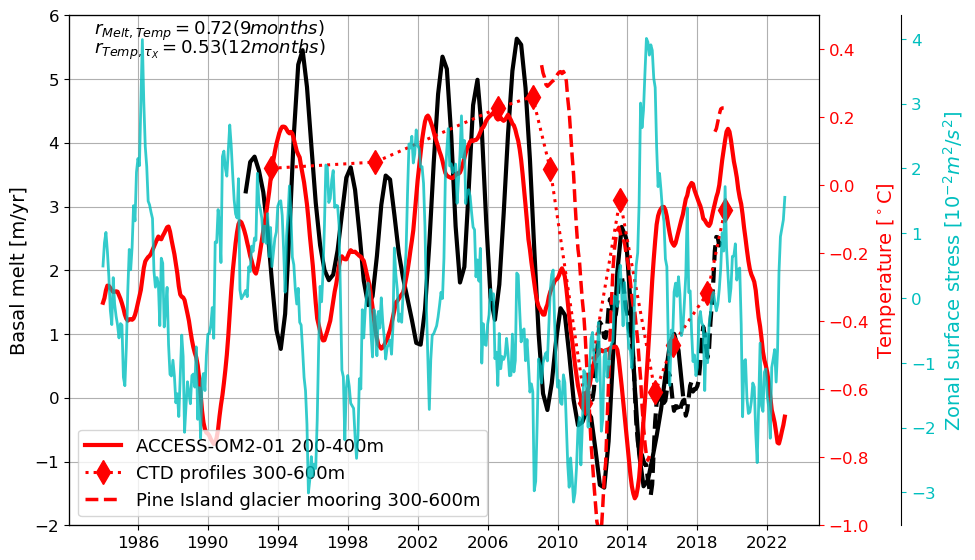

In [14]:
fig = plt.figure(figsize=(10,6))
ax2 = plt.axes([0.07,0.07,0.75,0.85])
# Basal melting on left yaxis: Relative to averages of overlapping period
(-pib_meltid+pib_meltid.sel(time=slice('2011-01-01','2017-12-31')).mean('time')).rolling(time=4,center=True).mean().plot(ax=ax2,color='k', lw=3, label='Paolo')
# Davison
(dav_pib_melt-dav_pib_melt.sel(time=slice('2011-01-01','2017-12-31')).mean('time'))[8:-9].rolling(time=12,center=True).mean().plot(ax=ax2,color='k', lw=3, ls='--', label='Davison')

# Temperatures on right y-axis
axb = ax2.twinx()
# Surface stress on second right y-axis
axc = ax2.twinx()
axc.spines.right.set_position(("axes", 1.11))
# TS-PIG
axb.plot(ts_pibsam.time, (ts_pibsam).chunk(time=-1).rolling(time=12,center=True).mean(), 'r', label='ACCESS-OM2-01 200-400m' , lw=3)
# AS Obs
pibavg_xr.sel(lev = slice(300,600)).mean('lev').plot(ax=axb,marker='d', markersize=12, lw=2.2,label='CTD profiles 300-600m',color='r', ls=':')
t_moor.sel(lev = slice(300,600)).mean('lev').chunk(time=-1).rolling(time=12,center=True).mean().plot(ax=axb, lw=2.5,label='Pine Island glacier mooring 300-600m',color='r',ls='--')
t_moor.sel(lev = slice(300,600)).mean('lev').chunk(time=-1).rolling(time=5,center=True).mean()[-30:].plot(ax=axb, lw=2.5,color='r', ls='--')

# tauX
p3, = axc.plot(taux_asm.time,100*(taux_asm.groupby('time.month')-taux_asm.groupby('time.month').mean('time')).chunk(time=-1).rolling(time=12, center=True).mean(),color='c', lw=2, zorder=0, alpha=.8,label=r'$\tau_X')

ax2.grid()
ax2.set_ylabel('Basal melt [m/yr]', color ='k',fontsize=14)
ax2.tick_params('y', colors='k', labelsize=12)
ax2.tick_params('x', colors='k', labelsize=12)
#ax2.set_ylim([-0.7,4.5])
ax2.set_ylim([-2,6])
ax2.set_xlabel('')
ax2.set_xticks(ticks=ts_pibsam.time[30::48])
ax2.text(ts_pibsam.time[0],5.7,r'$r_{Melt,Temp} = 0.72 (9 months)$',color='k',fontsize=13)
ax2.text(ts_pibsam.time[0],5.4,r'$r_{Temp, \tau_X} = 0.53 (12 months)$',color='k',fontsize=13)
ax2.set_title('')
axb.set_ylabel(r'Temperature [$^\circ$C]', color = 'r',fontsize=14)
axb.tick_params('y', colors='r', labelsize=12)
axb.tick_params('x', colors='k', labelsize=12)
axb.legend(fontsize=13, loc='lower left')
axb.set_ylim([-1,0.5])
axc.set_ylabel('Zonal surface stress [$10^{-2}m^2/s^2$]', color = 'c',fontsize=14)
axc.set_xlabel('Time',color='k', fontsize=14)
axc.tick_params('y', colors='c', labelsize=12)

#plt.savefig('/home/581/or6852/plots/figures/response2_fig1_v2.png')